In [141]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from unidecode import unidecode
import missingno as msno

from imblearn.over_sampling import SMOTE
import joblib

from sklearn.inspection import PartialDependenceDisplay
from sklearn.model_selection import (train_test_split, RandomizedSearchCV)
from sklearn.metrics import (accuracy_score, precision_score,
                             recall_score, f1_score, roc_curve, auc, roc_auc_score)
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.impute import KNNImputer
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score
from sklearn.model_selection import KFold
import numpy as np
import pandas as pd

from xgboost import XGBClassifier

import eli5
from eli5.sklearn import PermutationImportance
from lime.lime_tabular import LimeTabularExplainer

import warnings
from sklearn.exceptions import UndefinedMetricWarning


pd.plotting.register_matplotlib_converters()
%matplotlib inline

%load_ext autoreload
%autoreload 2
from help_tool import help_tool


"""Setting graph parameters"""
sns.set_theme(style='whitegrid')
sns.set_palette('husl')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [339]:
titanic = help_tool.csv_download(r'Archive\spaceship-titanic\train.csv')
test = help_tool.csv_download(r'Archive\spaceship-titanic\test.csv')

# EDA
* Dataset has 8693 observations and 14 features
* Some features are missing 2% of their data
* No duplicates

In [325]:
help_tool.first_look(titanic)

Dataset has 8693 observations and 14 features
Columns with all empty values []
Dataset has 0 duplicates


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
dtypes,object,object,object,object,object,float64,object,float64,float64,float64,float64,float64,object,bool
"Null values, Count",0,201,217,199,182,179,203,181,183,208,183,188,200,0
"Null values, %",0.0,2.3,2.5,2.3,2.1,2.1,2.3,2.1,2.1,2.4,2.1,2.2,2.3,0.0


In [ ]:
binaruy_features = ['CryoSleep', 'VIP', 'Transported']

## Deck T
Deck T has only 5 values and will be removed

In [340]:
def cleaning(df):
    # Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group.
    df[['Group', 'Group_Id']] = df['PassengerId'].str.split('_', expand=True)

    # Form deck/num/side, where side can be either P for Port or S for Starboard.
    df[['Deck', 'Deck_num', 'Side']] = df['Cabin'].str.split('/', expand=True)

    df[['First_Name', 'Last_Name']] = df['Name'].str.split(' ', expand=True)

    df['Deck'] = df['Deck'].replace({'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7, 'T': -1})

    df.loc[df['Side'] == 'S', 'Side_S'] = 1
    df.loc[df['Side'] == 'P', 'Side_S'] = 0

    df[['Group', 'Group_Id', 'Deck_num']] = df[['Group', 'Group_Id', 'Deck_num']].astype(float)

    for feature in binaruy_features:
        try:
            titanic[feature] = titanic[feature].astype(int)
        except: 
            titanic[feature] = titanic[feature].astype(float)


    df.drop(columns=['PassengerId', 'Name', 'Side'], inplace=True)
    return df

titanic = cleaning(titanic)
test = cleaning(test)

In [341]:
titanic[titanic['Deck'] == 8]

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Group,Group_Id,Deck,Deck_num,First_Name,Last_Name,Side_S
1004,NaN,0.0,T/0/P,TRAPPIST-1e,35.0,0.0,415.0,1328.0,0.0,14.0,60.0,0,1071.0,1.0,8.0,0.0,Alraida,Dingauge,0.0
2254,Europa,0.0,T/1/P,TRAPPIST-1e,42.0,0.0,0.0,1829.0,2.0,3133.0,2447.0,0,2414.0,1.0,8.0,1.0,Mergak,Headfair,0.0
2734,Europa,0.0,T/2/P,TRAPPIST-1e,33.0,0.0,0.0,28.0,0.0,6841.0,543.0,0,2935.0,1.0,8.0,2.0,NaN,NaN,0.0
2763,Europa,0.0,T/3/P,TRAPPIST-1e,38.0,0.0,0.0,3135.0,0.0,26.0,3.0,1,2971.0,1.0,8.0,3.0,Pent,Sessiouse,0.0
4565,Europa,NaN,T/2/S,TRAPPIST-1e,37.0,0.0,1721.0,667.0,NaN,28.0,1362.0,0,4863.0,1.0,8.0,2.0,Phacton,Unsible,1.0


In [342]:
titanic.head()

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Group,Group_Id,Deck,Deck_num,First_Name,Last_Name,Side_S
0,Europa,0.0,B/0/P,TRAPPIST-1e,39.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1.0,1.0,2.0,0.0,Maham,Ofracculy,0.0
1,Earth,0.0,F/0/S,TRAPPIST-1e,24.0,0.0,109.0,9.0,25.0,549.0,44.0,1,2.0,1.0,6.0,0.0,Juanna,Vines,1.0
2,Europa,0.0,A/0/S,TRAPPIST-1e,58.0,1.0,43.0,3576.0,0.0,6715.0,49.0,0,3.0,1.0,1.0,0.0,Altark,Susent,1.0
3,Europa,0.0,A/0/S,TRAPPIST-1e,33.0,0.0,0.0,1283.0,371.0,3329.0,193.0,0,3.0,2.0,1.0,0.0,Solam,Susent,1.0
4,Earth,0.0,F/1/S,TRAPPIST-1e,16.0,0.0,303.0,70.0,151.0,565.0,2.0,1,4.0,1.0,6.0,1.0,Willy,Santantines,1.0


Age


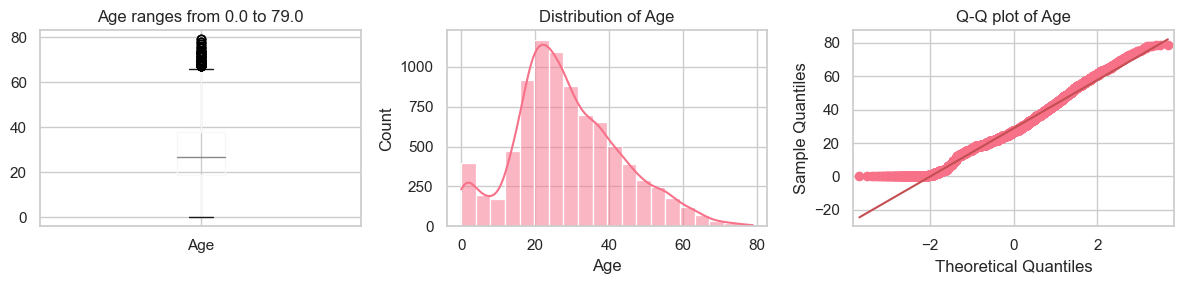

RoomService


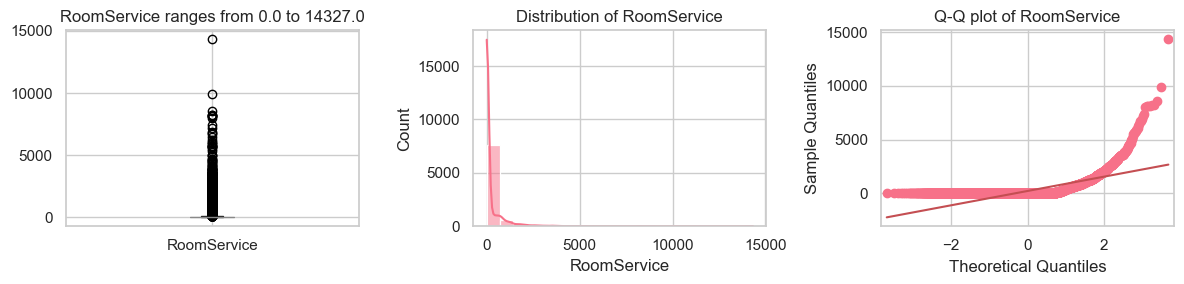

FoodCourt


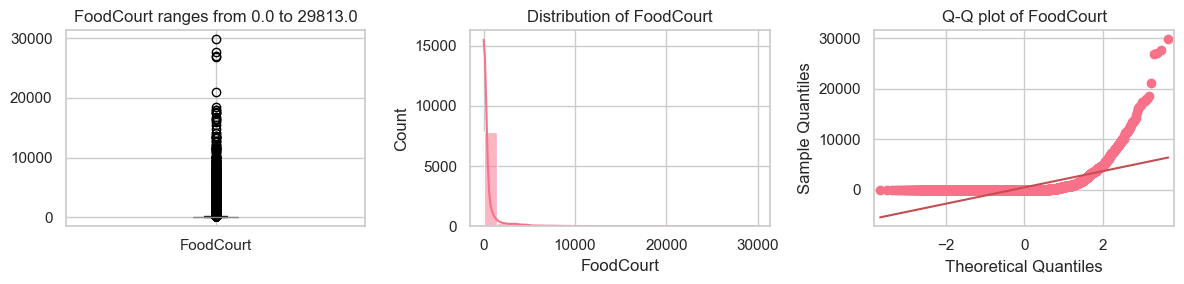

ShoppingMall


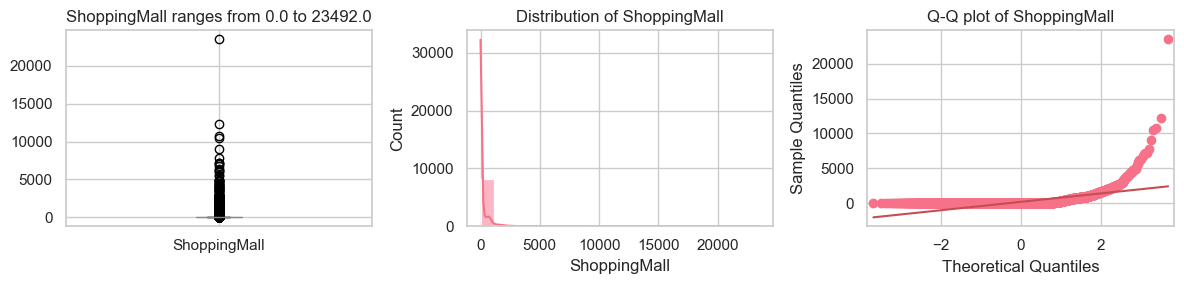

Spa


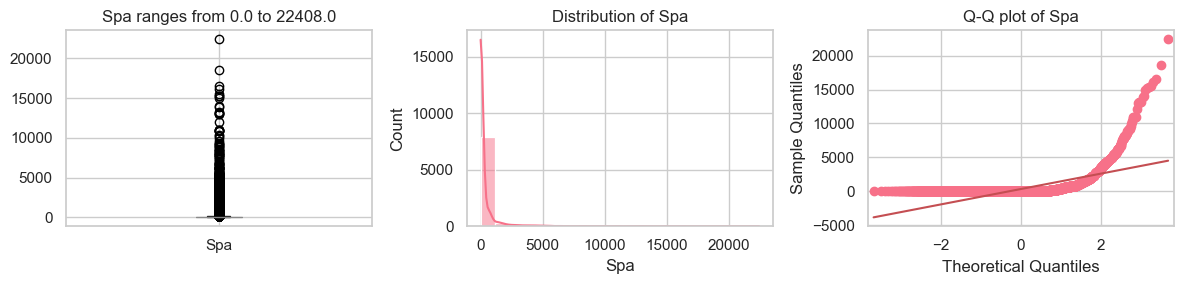

VRDeck


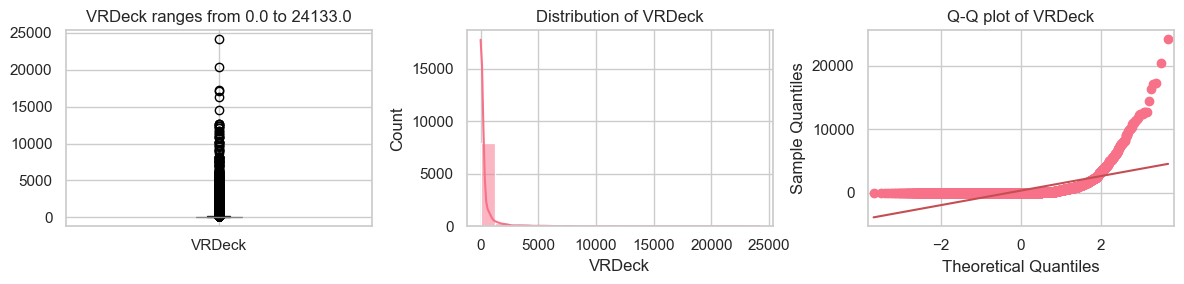

Group


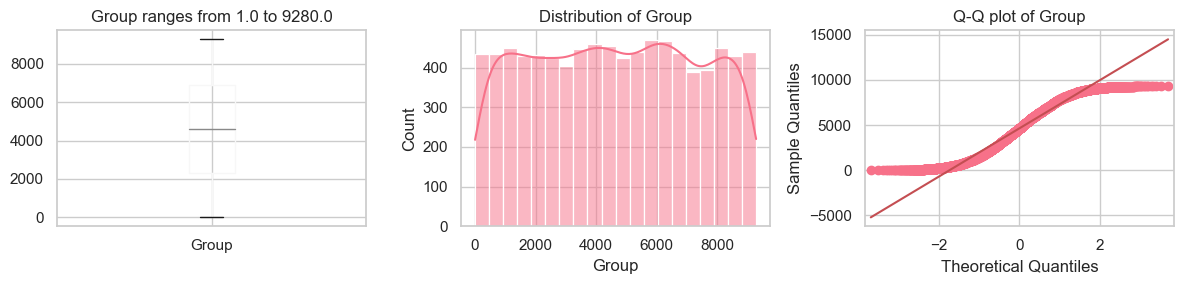

Deck


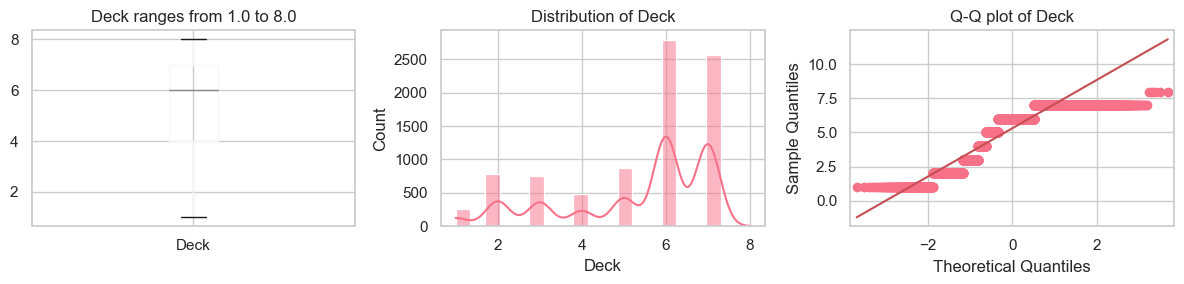

Deck_num


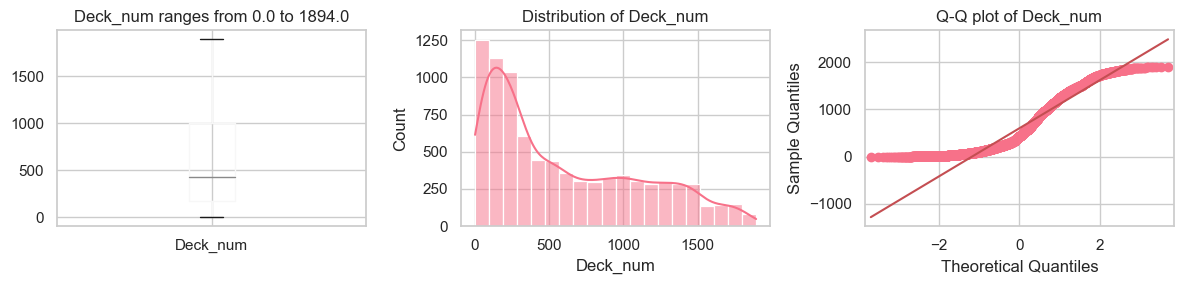

In [343]:
# titanic[['Group', 'Group_Id', 'Deck_num']] = titanic[['Group', 'Group_Id', 'Deck_num']].astype(float)
numerical_features = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Group', 'Deck_num']

help_tool.distribution_check(titanic[numerical_features])

In [344]:
category_features = ['HomePlanet', 'Destination', 'Deck', 'Side_S', 'Group_Id']
binaruy_features = ['CryoSleep', 'VIP', 'Transported']


for feature in binaruy_features:
    try:
        titanic[feature] = titanic[feature].astype(int)
    except: 
        titanic[feature] = titanic[feature].astype(float)

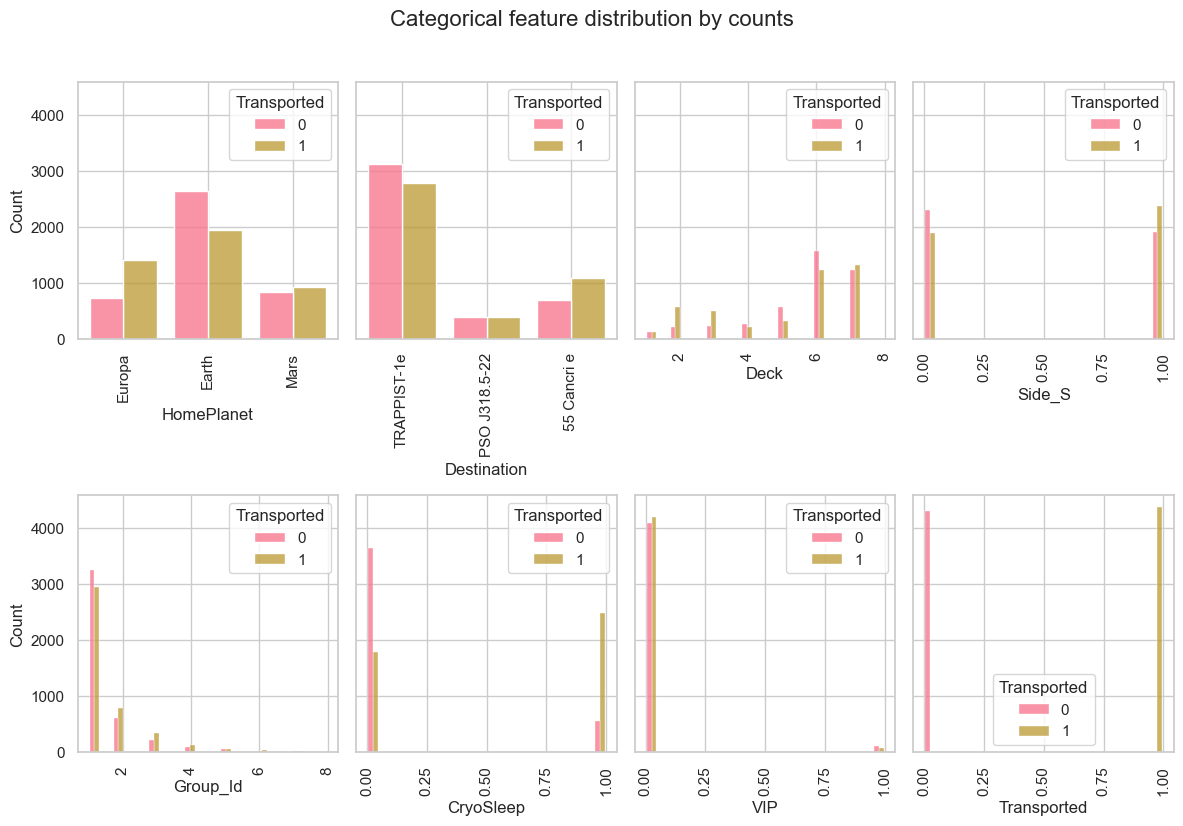

In [345]:
fig, axes = plt.subplots(2, 4, figsize=(12, 8), sharey=True)


axes = axes.flatten()

for i, col in enumerate(category_features + binaruy_features):
    sns.histplot(data=titanic, x=col, bins=20, multiple="dodge", shrink=.8, 
                 ax=axes[i], hue='Transported', legend=True)
    #axes[i].set_title(col)
    axes[i].tick_params(axis='x', rotation=90)

plt.suptitle(f"Categorical feature distribution by counts", size=16, y=1.02)
plt.tight_layout()
plt.show()

## Deck and group, homeplanet and destination
Homeplanet determines deck living area:
* Eurompa: 1-5
* Earth: 5-7
* Mars: 4-6

Homeplanet should not be used in modeling as it can be derived from another column

In [382]:
titanic

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Group,Group_Id,Deck,Deck_num,First_Name,Last_Name,Side_S
0,Europa,0.0,B/0/P,TRAPPIST-1e,39.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1.0,1.0,2.0,0.0,Maham,Ofracculy,0.0
1,Earth,0.0,F/0/S,TRAPPIST-1e,24.0,0.0,109.0,9.0,25.0,549.0,44.0,1,2.0,1.0,6.0,0.0,Juanna,Vines,1.0
2,Europa,0.0,A/0/S,TRAPPIST-1e,58.0,1.0,43.0,3576.0,0.0,6715.0,49.0,0,3.0,1.0,1.0,0.0,Altark,Susent,1.0
3,Europa,0.0,A/0/S,TRAPPIST-1e,33.0,0.0,0.0,1283.0,371.0,3329.0,193.0,0,3.0,2.0,1.0,0.0,Solam,Susent,1.0
4,Earth,0.0,F/1/S,TRAPPIST-1e,16.0,0.0,303.0,70.0,151.0,565.0,2.0,1,4.0,1.0,6.0,1.0,Willy,Santantines,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,Europa,0.0,A/98/P,55 Cancri e,41.0,1.0,0.0,6819.0,0.0,1643.0,74.0,0,9276.0,1.0,1.0,98.0,Gravior,Noxnuther,0.0
8689,Earth,1.0,G/1499/S,PSO J318.5-22,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0,9278.0,1.0,7.0,1499.0,Kurta,Mondalley,1.0
8690,Earth,0.0,G/1500/S,TRAPPIST-1e,26.0,0.0,0.0,0.0,1872.0,1.0,0.0,1,9279.0,1.0,7.0,1500.0,Fayey,Connon,1.0
8691,Europa,0.0,E/608/S,55 Cancri e,32.0,0.0,0.0,1049.0,0.0,353.0,3235.0,0,9280.0,1.0,5.0,608.0,Celeon,Hontichre,1.0


<Figure size 1200x800 with 0 Axes>

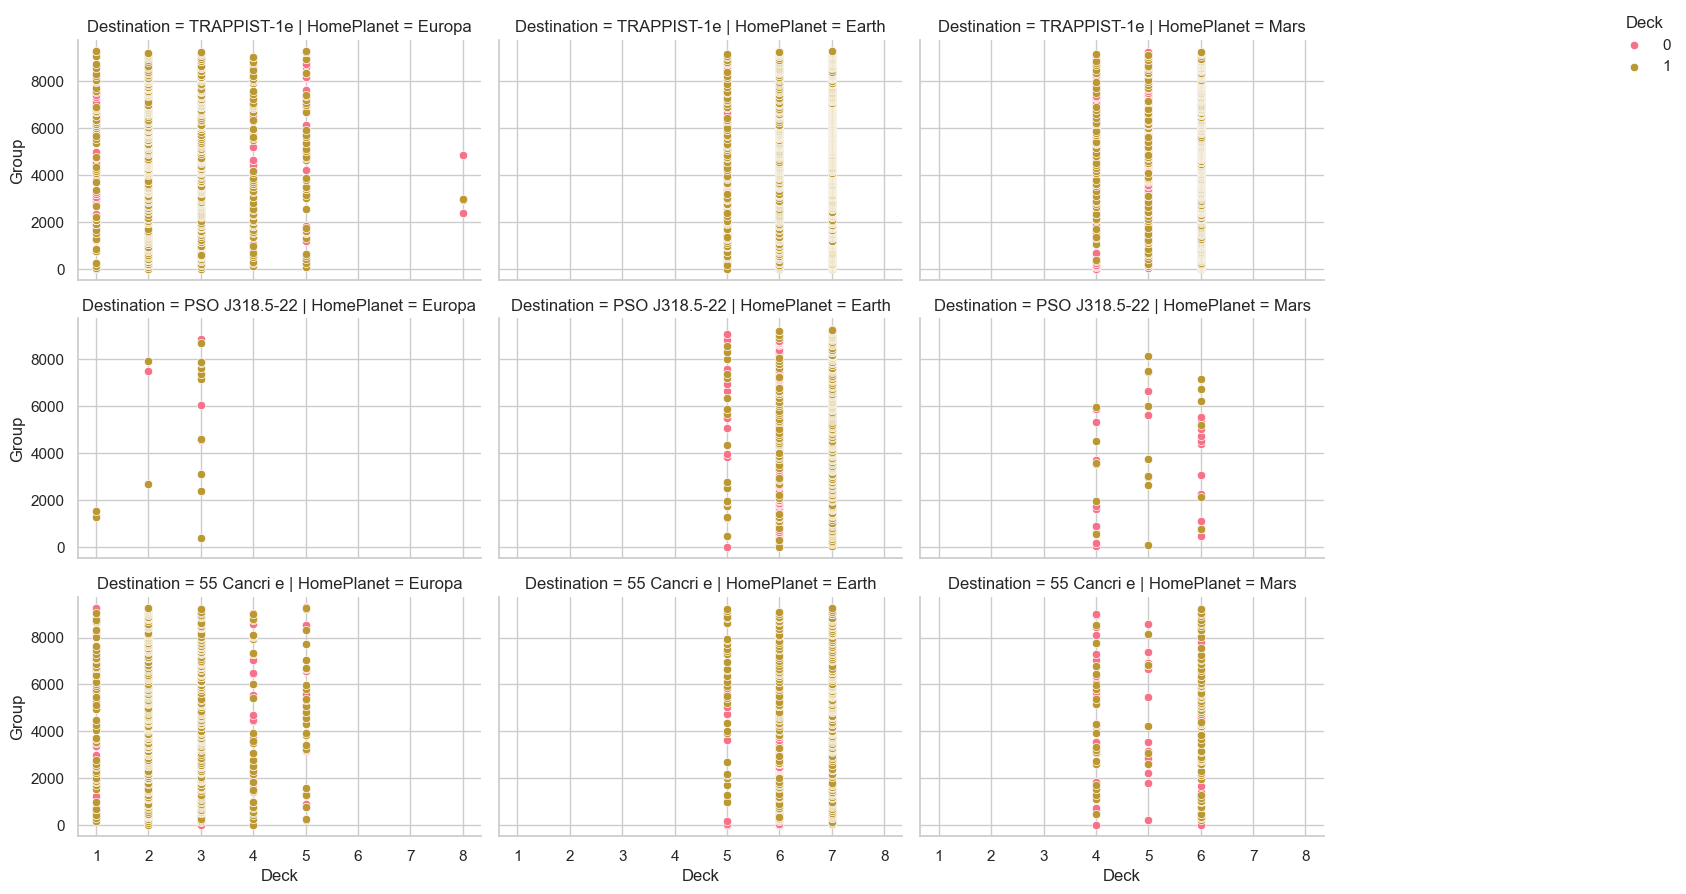

In [383]:
plt.figure(figsize=(12, 8)) 

g = sns.FacetGrid(titanic, row="Destination", col="HomePlanet", hue='Transported', height=3, aspect=1.5)

g.map(sns.scatterplot, "Deck", "Group")

g.add_legend(title='Deck', loc='upper right', bbox_to_anchor=(1.2, 1))

plt.show()

# Mutual information gain

In [298]:
from sklearn.feature_selection import mutual_info_classif

In [ ]:
titanic.columns


Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name', 'Transported', 'Group', 'Group_Id', 'Deck', 'Deck_num', 'Side',
       'First_Name', 'Last_Name'],
      dtype='object')

c:\Users\Gintare\Desktop\Study\Module3\Sprint3\New_code\Spaceship_Titanic\help_tool\help_tool.py:101: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr(method=method)


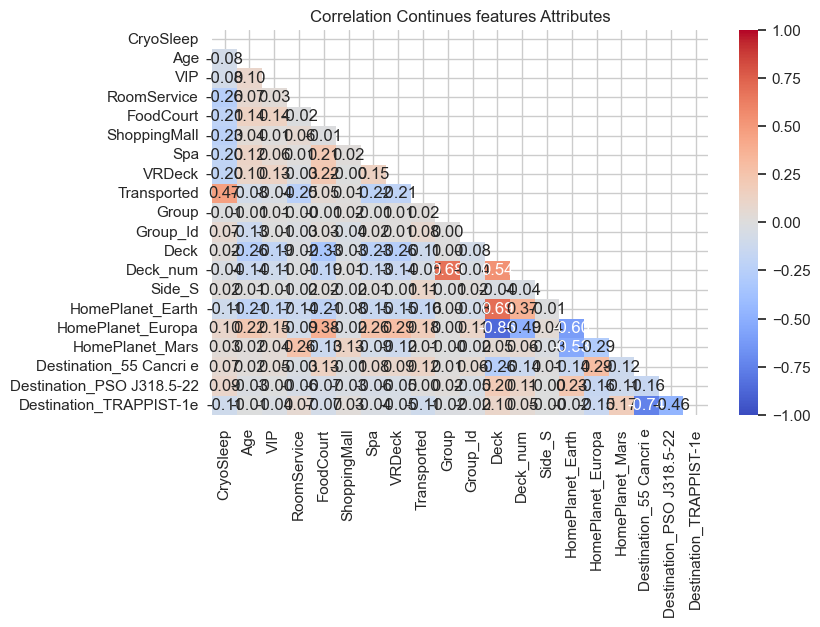

In [357]:
help_tool.heatmap(titanic_dummies,
                  'Continues Features', 'pearson')

In [347]:
titanic_dummies = help_tool.dummy_columns(
    titanic, ['HomePlanet', 'Destination'])

In [353]:
titanic.shape

(8693, 19)

In [348]:
titanic_dummies.dropna(inplace=True)
titanic_dummies.shape

(6918, 23)

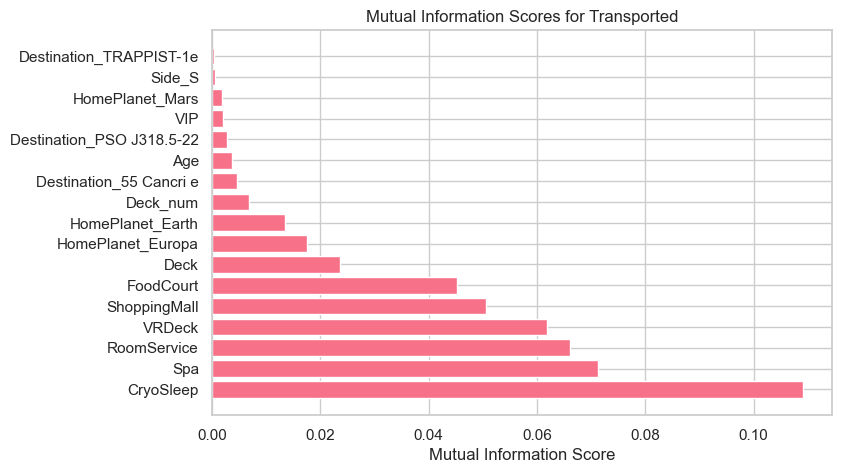

In [355]:
X = titanic_dummies.drop(['Transported', 'Cabin', 'Group', 'Group_Id', 'First_Name', 'Last_Name'], axis=1)
y = titanic_dummies['Transported']

# Compute mutual information scores
mi_scores = pd.DataFrame(mutual_info_classif(
    X, y), index=X.columns, columns=['Mutual Information Gain'])
mi_scores.sort_values(by='Mutual Information Gain',
                      ascending=False, inplace=True)

# Visualize the scores
width = np.arange(len(mi_scores))
ticks = list(mi_scores.index)

plt.figure(dpi=100, figsize=(8, 5))
plt.barh(width, mi_scores['Mutual Information Gain'])
plt.yticks(width, ticks)
plt.xlabel("Mutual Information Score")
plt.title("Mutual Information Scores for Transported")
plt.show()

# Where are the missing values?
## Homeplanet
People in a group are often family members, but not always. For example, last name Acobsond is share by people in different groups.

In [256]:
titanic[['Group', 'Last_Name']].value_counts().to_frame().reset_index().rename(columns={0: 'Count'}).sort_values(by='Last_Name').head()

,Group,Last_Name,Count
165,6905.0,Acobson,3
5155,4220.0,Acobson,1
4921,991.0,Acobsond,1
4210,2220.0,Acobsond,1
2212,5671.0,Acobsond,1


In [292]:
titanic[titanic['Last_Name'] == 'Acobson']

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Group,Group_Id,Deck,Deck_num,Side,First_Name,Last_Name
3957,Earth,0.0,E/263/P,TRAPPIST-1e,31.0,0.0,553.0,224.0,9.0,1.0,0.0,0,4220.0,1.0,E,263.0,P,Tine,Acobson
6540,Earth,0.0,F/1322/S,TRAPPIST-1e,39.0,0.0,130.0,741.0,0.0,0.0,0.0,0,6905.0,1.0,F,1322.0,S,Vana,Acobson
6541,Earth,0.0,E/460/S,TRAPPIST-1e,15.0,0.0,0.0,0.0,0.0,938.0,44.0,0,6905.0,2.0,E,460.0,S,Lilasa,Acobson
6542,Earth,0.0,F/1322/S,55 Cancri e,16.0,0.0,43.0,3.0,750.0,0.0,0.0,1,6905.0,3.0,F,1322.0,S,Gaylah,Acobson


Maybe the missing group features are available in Test set? After checking - no

In [291]:
def finding_group_attributes(missing_feature: str, feature_groups: list):
    """ Finding missing Group attributes in Test set and printing out their availability."""
    df1 = titanic[titanic[missing_feature].isna()][feature_groups]
    df2 = test[[missing_feature] + feature_groups]

    merged_df = pd.merge(df1, df2, how='left', on=feature_groups)
    merged_df = merged_df[~merged_df[missing_feature].isna()]

    print(f"Missing '{missing_feature}' available: {merged_df.shape[0]}")

for feature in ['Cabin', 'HomePlanet', 'VIP', 'CryoSleep']:
    finding_group_attributes(feature, ['Group', 'Last_Name'])

Missing 'Cabin' available: 0
Missing 'HomePlanet' available: 0
Missing 'VIP' available: 0
Missing 'CryoSleep' available: 0


In [297]:
def missing_homeplanet(df):
    df.sort_values(['Last_Name', 'Group', 'Destination'], inplace=True)
    groups = df.groupby(['Last_Name', 'Group', 'Destination'])

    for (last_name, cabin, destination), group_df in groups:
        home_planet = group_df['HomePlanet'].dropna().iloc[0] if not group_df['HomePlanet'].isnull().all() else None

        mask = (df['Last_Name'] == last_name) & (df['Cabin'] == cabin) & (df['Destination'] == destination) & (df['HomePlanet'].isnull())
        df.loc[mask, 'HomePlanet'] = home_planet

    # Reset dataframe index if needed
    df.reset_index(drop=True, inplace=True)
    
    return df


titanic = missing_homeplanet(titanic)

In [293]:
help_tool.first_look(titanic)

Dataset has 8693 observations and 19 features
Columns with all empty values []
Dataset has 0 duplicates


,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Group,Group_Id,Deck,Deck_num,Side,First_Name,Last_Name
dtypes,object,float64,object,object,float64,float64,float64,float64,float64,float64,float64,int32,float64,float64,object,float64,object,object,object
"Null values, Count",201,217,199,182,179,203,181,183,208,183,188,0,0,0,199,199,199,200,200
"Null values, %",2.3,2.5,2.3,2.1,2.1,2.3,2.1,2.1,2.4,2.1,2.2,0.0,0.0,0.0,2.3,2.3,2.3,2.3,2.3


stroke_data_dummies = help_tool.dummy_columns(stroke_data, ['Work_type'])

# Scalling 0 to 1, as KNN is sensitive to neighbor distince

stroke_data_dummies['Age_rescaled'] = stroke_data_dummies['Age']/100

stroke_data_dummies['Avg_glucose_level_rescaled'] = stroke_data_dummies['Avg_glucose_level']/300

stroke_data_dummies['Bmi_rescaled'] = stroke_data_dummies['Bmi']/100


# Removing non-scalled features

def_imputation = stroke_data_dummies.drop(
    ['Bmi', 'Avg_glucose_level', 'Age', 'Bmi_was_missing', 'Smoking_status_was_missing'], axis=1)



# KNNImputer for NaN values

imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')

imputer.fit(def_imputation)

imputed_features = imputer.transform(def_imputation)

imputed_df = pd.DataFrame(imputed_features, columns=def_imputation.columns)



# Rescalling back BMI

imputed_df['Age'] = imputed_df['Age_rescaled']*100

imputed_df['Avg_glucose_level'] = imputed_df['Avg_glucose_level_rescaled']*300

imputed_df['Bmi'] = imputed_df['Bmi_rescaled']*100

stroke_data_dummies = imputed_df.drop(
    ['Age_rescaled', 'Avg_glucose_level_rescaled', 'Bmi_rescaled'], axis=1)

# Reseting indexes as they got uneven after imputation
imputed_df.reset_index(drop=True, inplace=True)
stroke_data.reset_index(drop=True, inplace=True)

# Assigning new values
stroke_data['Bmi'] = imputed_df['Bmi']
stroke_data['Smoking_status'] = imputed_df['Smoking_status'].round().astype(int)

# Rewriting stroke_data_dummies to fit the new structure
stroke_data_dummies = help_tool.dummy_columns(stroke_data, ['Work_type'])